<a href="https://colab.research.google.com/github/msommerfe/CAS_Applied_Data_Science/blob/main/CAS_Final_Project/OCR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
!pip install tensorflow

In [223]:
import numpy as np
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
import string

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
MAX_HIGHT = 128
MAX_WIDTH = 256
IMG_FOLDER = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
LABELS_JSON = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/v011_labels_small.json'
#Dont use @ in the alphabet. if you need you need to change the fillup char
ALPHABETS = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 0123456789"
ALPHABETS = string.digits + string.ascii_letters + '!?.-() '
max_str_len = 24 # max length of input labels
num_of_characters = len(ALPHABETS) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 128 # max length of predicted labels
BATCH_SIZE = 16


In [2]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Reading the json {Image_filename, "test on Image"}
with open(LABELS_JSON) as f:
    data = list(json.load(f).items())

#Reduced to just 500, change it to all for real training
keyVal = np.array(data[:100])
y_all = keyVal[:,1]
x_all_img_file_name = keyVal[:,0]
x_all_img_total_path = np.array([make_total_path(imgName) for imgName in x_all_img_file_name])

In [3]:
### Converting Chars to nums is better for ML
def label_to_num(label):
    #fills up the label with @
    label = label.ljust(max_str_len, '@')
    label_num = []
    for ch in label:
      label_num.append(ALPHABETS.find(ch) if ALPHABETS.find(ch)!=-1 else -1)
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=ALPHABETS[ch]
    return ret


In [4]:
# Add the total path to image name
def make_total_path(imgName):
  return IMG_FOLDER + imgName

In [ ]:
#Convert Char Labels to num Labels
y_all_numbers = np.array([label_to_num(xi) for xi in y_all])

#rotate that x = Width and y = hight
#x_all_rotate = np.array([rotateImage(xi) for xi in x_all])

#and reshape
x_train_rotate_reshaped = np.array(x_all_rotate).reshape(-1, MAX_WIDTH, MAX_HIGHT, 1)

In [224]:
# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(ALPHABETS), num_oov_indices=0, mask_token=None
)

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

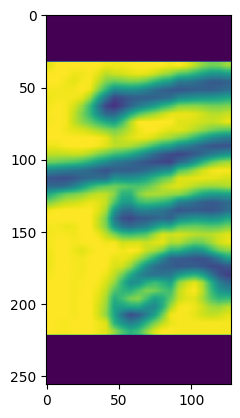

(128, 256, 1)


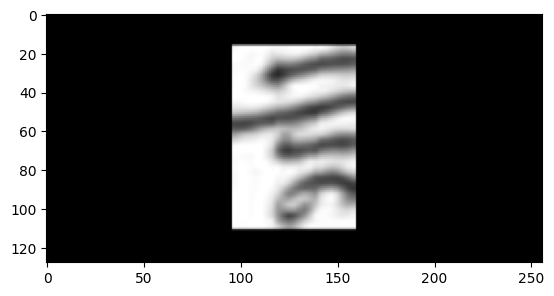

In [174]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images [0...255] as a tensor
def resize_to_desired_shape_for_tf(img):
    #display(type(img))
    #Debug
    #tf.print(img[1, 1])

    #img = img.numpy()     #convert to np.array. For me mor easy to work with
    #img = img[:,:,0]      #Cut of last Dimension
    #(h, w) = img.shape

    #Scale all Images down that image width is max_width
    #scaleFactor = MAX_WIDTH / w
    #if scaleFactor < 1:
    #  img = cv2.resize(img, None, fx = scaleFactor, fy = scaleFactor)
    #  (h, w) = img.shape

    img = tf.image.resize_with_pad(img, target_height=MAX_HIGHT, target_width=MAX_WIDTH, antialias=True)
    # Unlikely, but just in case, if hight is still greater than max_hight, scale only hight down to max_hight
    #if h > MAX_HIGHT:
    #   img = cv2.resize(img, None, fx = 1, fy = (MAX_HIGHT/h))

    #creates blank white image with size max_hight x max_width
    #final_img = np.ones([MAX_HIGHT, MAX_WIDTH])*255 # blank white image

    # fills the blank image with resized imput image
    #final_img[:h, :w] = img
    #final_img = final_img.reshape(MAX_HIGHT,MAX_WIDTH,1)  #Putting back the 3 Dimension (important for tf)
    #return tf.convert_to_tensor(final_img)                # Converting back to tensor

    return img

plt.imshow(bla["image"])
plt.show()
_img = resize_to_desired_shape_for_tf(bla["image"])
#display(type(_img))
plt.imshow(_img,cmap="gray")
print(_img.shape)


In [ ]:
debugIMG = bla["image"]

In [213]:
# Mapping characters to integers
char_to_num = tensorflow.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(ALPHABETS), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

In [206]:
def process_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    #img = tf.io.decode_jpeg(img)

        # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # dimension to correspond to the width of the image.
    img = tf.image.resize_with_pad(img, target_height=MAX_HIGHT, target_width=MAX_WIDTH,antialias=True)


    #img = resize_to_desired_shape_for_tf(img)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [MAX_HIGHT, MAX_WIDTH])
    # 5. Transpose the image because we want the time

    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    #label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    #label = label_to_num(label)
    label = char_to_num(label)
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


bla = process_single_sample(x_all_img_total_path[1],y_all[1])

plt.imshow(bla["image"],cmap="gray")
plt.show()
print(bla["label"])

NameError: name 'char_to_num' is not defined

In [201]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_all_img_total_path, y_all))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Create the OCR Model

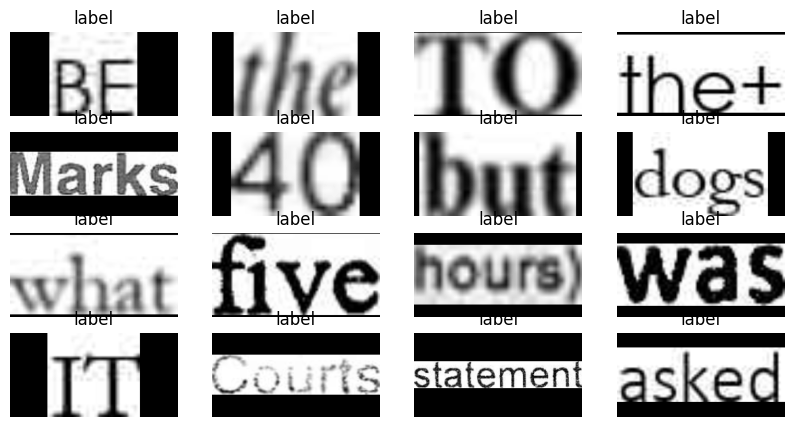

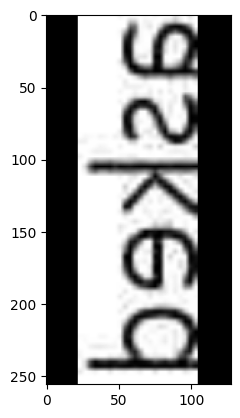

In [202]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        #label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title("label")
        ax[i // 4, i % 4].axis("off")
plt.show()
plt.imshow(img,cmap="gray")
plt.show()

In [ ]:
type(train_dataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

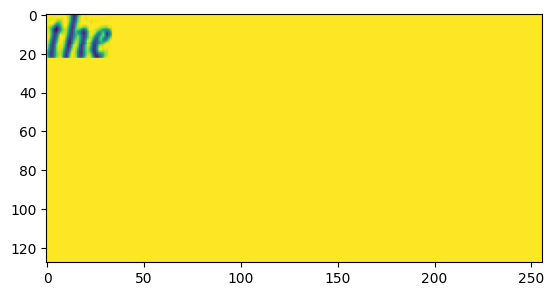

tensorflow.python.framework.ops.EagerTensor

TensorShape([128, 256, 1])

int

tensorflow.python.framework.ops.EagerTensor

(128, 256, 1)


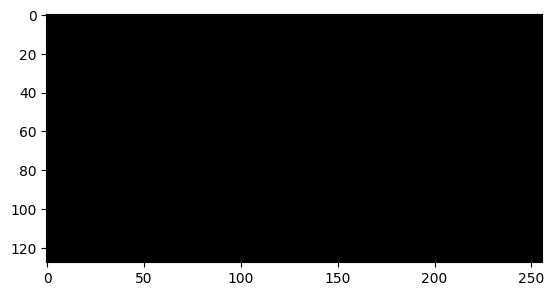

In [53]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images [0...255] as a tensor
def resize_to_desired_shape_for_tf____JUSTATRY(img):
    display(type(img))
    display(img.shape)
    #Debug tf.print(img[15, 15])

    #img = img.numpy()     #convert to np.array. For me mor easy to work with
    #img = img[:,:,0]      #Cut of last Dimension
    h = img.shape[0]
    w = img.shape[0]
    display(type(w))

    #Scale all Images down that image width is max_width
    scaleFactor = MAX_WIDTH / w
    if scaleFactor < 1:
      img = tf.image.resize(img, [MAX_HIGHT, MAX_WIDTH,1])
      (h, w) = img.shape
      display(img.shape)
    # Unlikely, but just in case, if hight is still greater than max_hight, scale only hight down to max_hight
    #if h > MAX_HIGHT:
      # img = cv2.resize(img, None, fx = 1, fy = (MAX_HIGHT/h))

    #creates blank white image with size max_hight x max_width
    final_img = tf.ones([MAX_HIGHT, MAX_WIDTH,1], tf.int32)

    #np.ones([MAX_HIGHT, MAX_WIDTH])*255 # blank white image

    # fills the blank image with resized imput image
    #final_img[:h, :w,1] = img
    #final_img = final_img.reshape(MAX_HIGHT,MAX_WIDTH,1)  #Putting back the 3 Dimension (important for tf)
    return tf.convert_to_tensor(final_img)                # Converting back to tensor


plt.imshow(bla["image"])
plt.show()
_img = resize_to_desired_shape_for_tf(bla["image"])
display(type(_img))
plt.imshow(_img,cmap="gray")
print(_img.shape)


In [ ]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_rotate_reshaped, y_all_numbers, test_size=0.2, random_state=42)

# Print as sanity check
print(y_train[3])
num_to_label(y_train[3])

[28 25 14 12 18 10 21 29 34 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


'specialty'

In [ ]:
input_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
label_length = np.ones(len(x_train)) # Dim Array = dim von x_train_rotate_reshaped
data_set = [x_train, y_train,input_length, label_length]
print(len(y_all_numbers))
print(x_train_rotate_reshaped[1].shape)

In [ ]:
x_train[0].shape

(256, 128, 1)

should


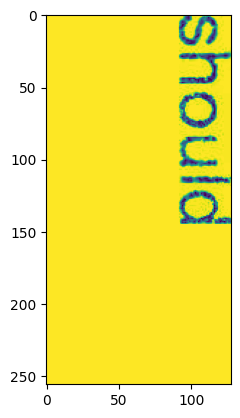

In [ ]:
print(num_to_label(y_all_numbers[455]))
plt.imshow(x_all_rotate[455])
plt.show()

#Building the Model

In [ ]:

# Evtl. Input umformatieren in einzeilig
input_data = Input(shape=(MAX_WIDTH, MAX_HIGHT, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((num_of_timestamps, 1024)), name='reshape')(inner)
inner = Dense(num_of_timestamps, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 128, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 128, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 256, 128, 32)      128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 256, 128, 32)      0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 64, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 64, 64)       18496     
                                                           

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)



In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
input_length

<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'input_length')>

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

In [ ]:
x_train.shape

(400, 256, 128, 1)

In [ ]:
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model_final.fit(data_set,
                 epochs=8, batch_size = 1,
                 validation_data=(x_test, y_test),
                 callbacks=[save_callback])


Epoch 1/8


ValueError: Target data is missing. Your model was compiled with loss={'ctc': <function <lambda> at 0x78b4f0ffe0e0>}, and therefore expects target data to be provided in `fit()`.